# LSP Ti-6Al-4V Depth Stress Scan

This notebook presents an example analysis of residual stresses at P61A.

###### Sample:
100 × 20 × 1 mm thick Ti-6Al-4V sheet with Laser Shock Peening treated surface.

###### Experiment parameters:
Measurements in transmission.
Incident beam 50 × 50 μm, detector 2Θ = 5.274° calibrated using NIST 640f powder.

###### Experimental procedure:
1. Orient the sample with surface parallel to the beam at half of the beam height.
2. Rotate the sample by Θ around x, so that the incident and diffracted beam fall at the same angle to its surface.
3. Perform *eu.chi* scan for every *eu.z* position for two *eu.phi* orientations 0° and 90°. *eu.z* puts the gauge volume at a certain depth in the sample, and for each depth a $sin^2(\psi)$ scan is performed for $\varphi \in \{0^{\circ}, 90^{\circ}\}$. For the purposes of $sin^2(\psi)$ method, *eu.phi* is $\varphi$ and *eu.chi* is $\psi$.
4. Diffraction patterns were analysed using P61A::Viewer. Peaks exported from the Viewer are the starting point of this analysis.

## Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from uncertainties import unumpy, ufloat

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# This has to be the path to P61AToolkit/src/py61a.
# If you are launching the notebook from P61AToolkit/src/notebooks it is correct,
# otherwise change it accordingly.
sys.path.append('../py61a')
from py61a.viewer_utils import read_peaks, valid_peaks, peak_id_str, group_by_motors
from py61a.cryst_utils import bragg, tau, mu
from py61a.stress import sin2psi, deviatoric_stresses, all_stresses

%matplotlib inline

## Definitions

In [2]:
# 2Theta angle
tth_ch1 = 5.274
# Main element in the alloy, will be used for absorption calculation
element = 'Ti'
# Diffraction elactic constants prepared using ISODEC https://www.nist.gov/services-resources/software/isodec
dec = pd.read_csv(r'../../data/dec/alphaTi.csv', index_col=None, comment='#')

## $d_0$ measurement preparation
A reference sample was measured to get the $d_0$ values for the diffraction peaks.

In [3]:
# read Viewer output
d0_data = read_peaks(r'../../data/peaks/TiLSP/Ti_1mm_d0_ref.csv')
# create a dataframe for storing d0 values
d0 = pd.DataFrame(columns=['h', 'k', 'l', 'd0', 'd0_std', 'en'])
for peak_id in valid_peaks(d0_data, valid_for='phase'):
    # calculating the d value from the peak center and 2Theta
    d_val = bragg(en=ufloat(d0_data[peak_id]['center'].mean(), d0_data[peak_id]['center'].std()), tth=tth_ch1)['d']
    # adding to the d0 dataframe as a new row
    d0.loc[d0.shape[0]] = {
        **{idx: d0_data[peak_id][idx].mean().astype(int) for idx in ('h', 'k', 'l')},
        'd0': d_val.nominal_value,
        'd0_std': d_val.std_dev,
        'en': d0_data[peak_id]['center'].mean()
    }
# showing results: hkl, measured d0, measured d0 standard deviation, energy of the peak
d0 = d0.sort_values(by='en').reset_index(drop=True)
print(d0)

    h  k  l        d0    d0_std          en
0   1  0  0  2.532843  0.000550   53.197829
1   0  0  2  2.335838  0.000622   57.684555
2   1  0  1  2.227108  0.000479   60.500767
3   1  0  2  1.717717  0.000366   78.442366
4   1  1  0  1.463043  0.000455   92.096946
5   1  0  3  1.327186  0.000373  101.524369
6   2  0  0  1.267117  0.000715  106.337267
7   1  1  2  1.240123  0.000234  108.651924
8   2  0  1  1.222798  0.000458  110.191368
9   0  0  4  1.168465  0.000659  115.315181
10  2  0  2  1.113966  0.000360  120.956806


## Deviatoric stress components
To calculate $(\sigma_{11} - \sigma_{33})$ and $(\sigma_{22} - \sigma_{33})$ one does not need to know $d_0$ precisely. This makes the results very robust.

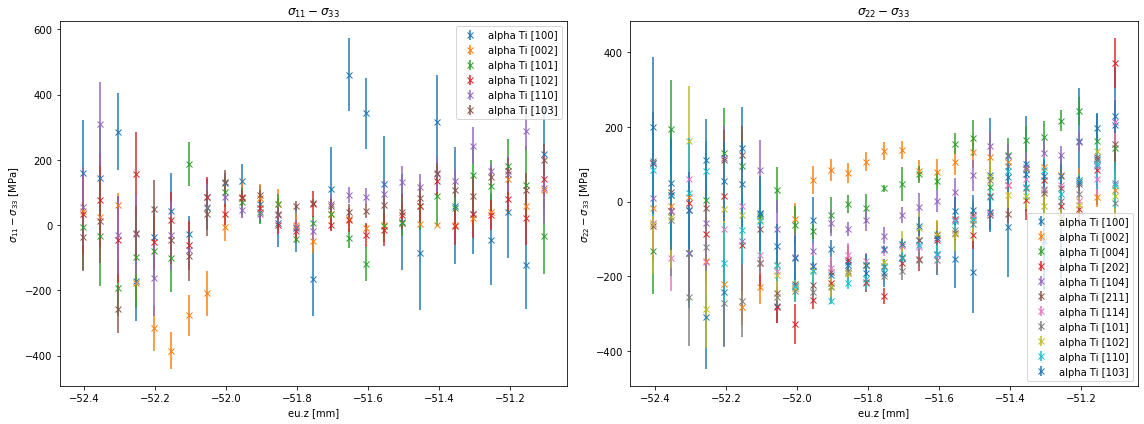

In [4]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

for peak_id in valid_peaks(dd, valid_for='sin2psi'):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 1e-3}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = deviatoric_stresses(dd, analysis, dec)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 6))
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.set_title(r'$\sigma_{11}-\sigma_{33}$')
ax2.set_title(r'$\sigma_{22}-\sigma_{33}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}-\sigma_{33}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}-\sigma_{33}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11-s33' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

## All measured stress components
Using the prepared $d_0$ values
### IMPORTANT:
These plots show all tensor components only as an example. Non-diagonal elements are incorrect, because for  $\sigma_{12}$ no measurements at $\varphi \in \{45^{\circ}, 135^{\circ}, 225^{\circ}, 315^{\circ}\}$ and for $\sigma_{13}$, $\sigma_{23}$ no measurements at $\varphi \in \{180^{\circ}, 270^{\circ}\}$ were performed.

Note that the $\sigma$ values for $[002]$ are really off. Given thaqt the deviatoric components (shown later) match, this probably means that the $d_0$ measurement for this peak was inaccurate.

No handles with labels found to put in legend.


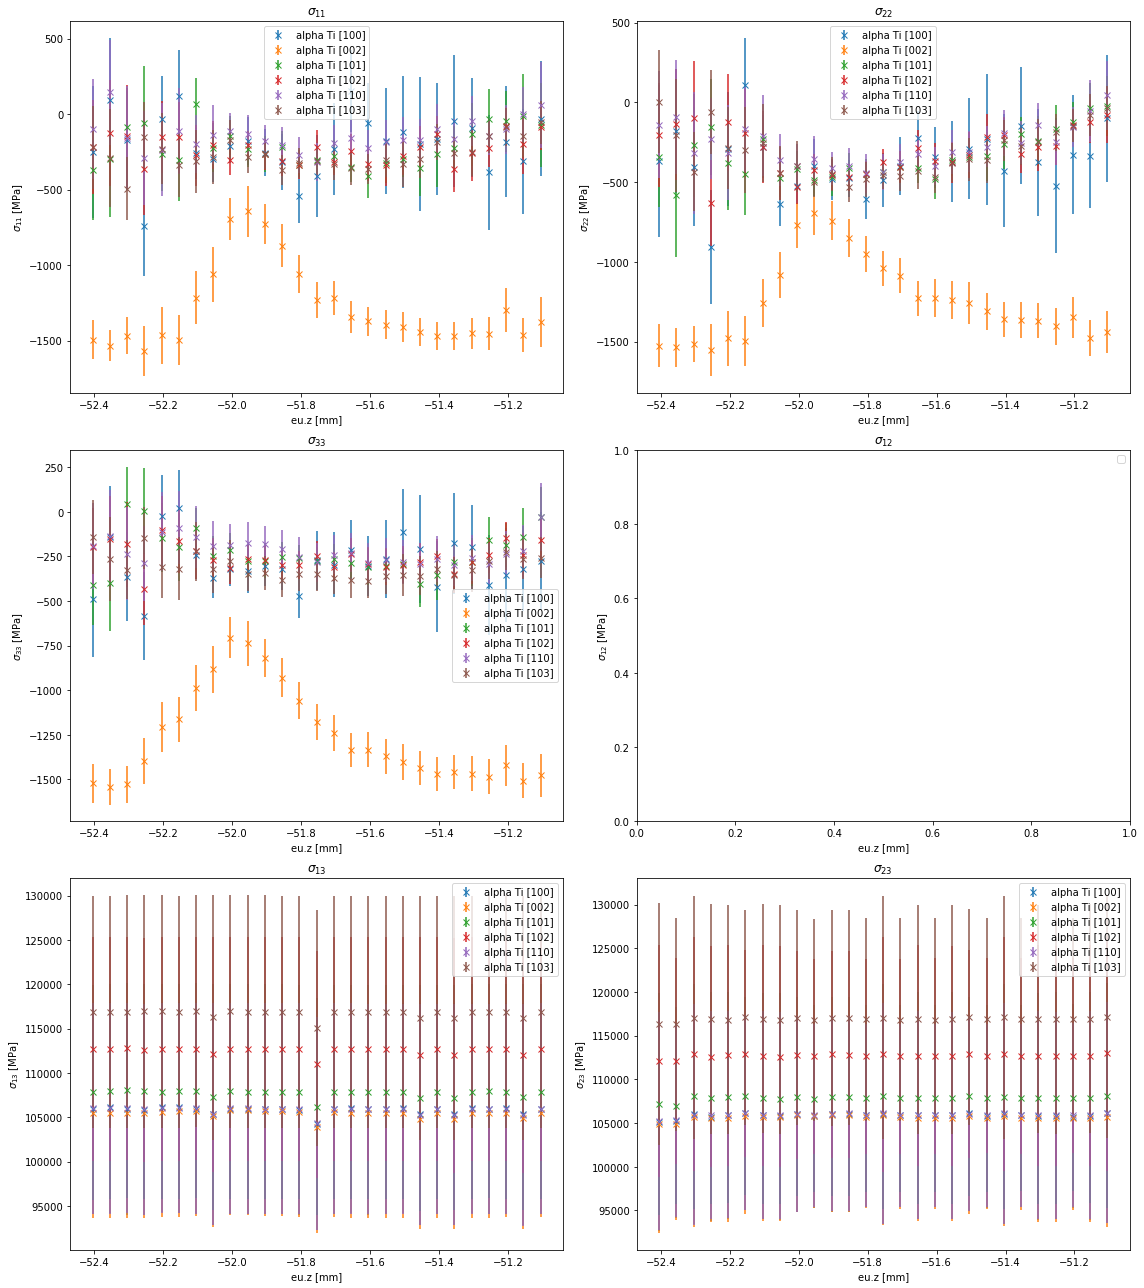

In [5]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

for peak_id in valid_peaks(dd, valid_for='sin2psi'):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 1e-3}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = all_stresses(dd, analysis, dec, d0)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1, ax2 = plt.subplot(321), plt.subplot(322)
ax3, ax4 = plt.subplot(323), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11}$')
ax2.set_title(r'$\sigma_{22}$')
ax3.set_title(r'$\sigma_{33}$')
ax4.set_title(r'$\sigma_{12}$')
ax5.set_title(r'$\sigma_{13}$')
ax6.set_title(r'$\sigma_{23}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11}$ [MPa]')
ax2.set_ylabel('$\sigma_{22}$ [MPa]')
ax3.set_ylabel('$\sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{12}$ [MPa]')
ax5.set_ylabel('$\sigma_{13}$ [MPa]')
ax6.set_ylabel('$\sigma_{23}$ [MPa]')

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if 's11' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's33' in stress[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's12' in stress[peak_id].columns:
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's12')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's12')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's13' in stress[peak_id].columns:
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's13')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's13')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

    if 's23' in stress[peak_id].columns:
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's23')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's23')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.tight_layout()
plt.show()

## Deviatoric component comparison: 
with $d_0$ vs without $d_0$

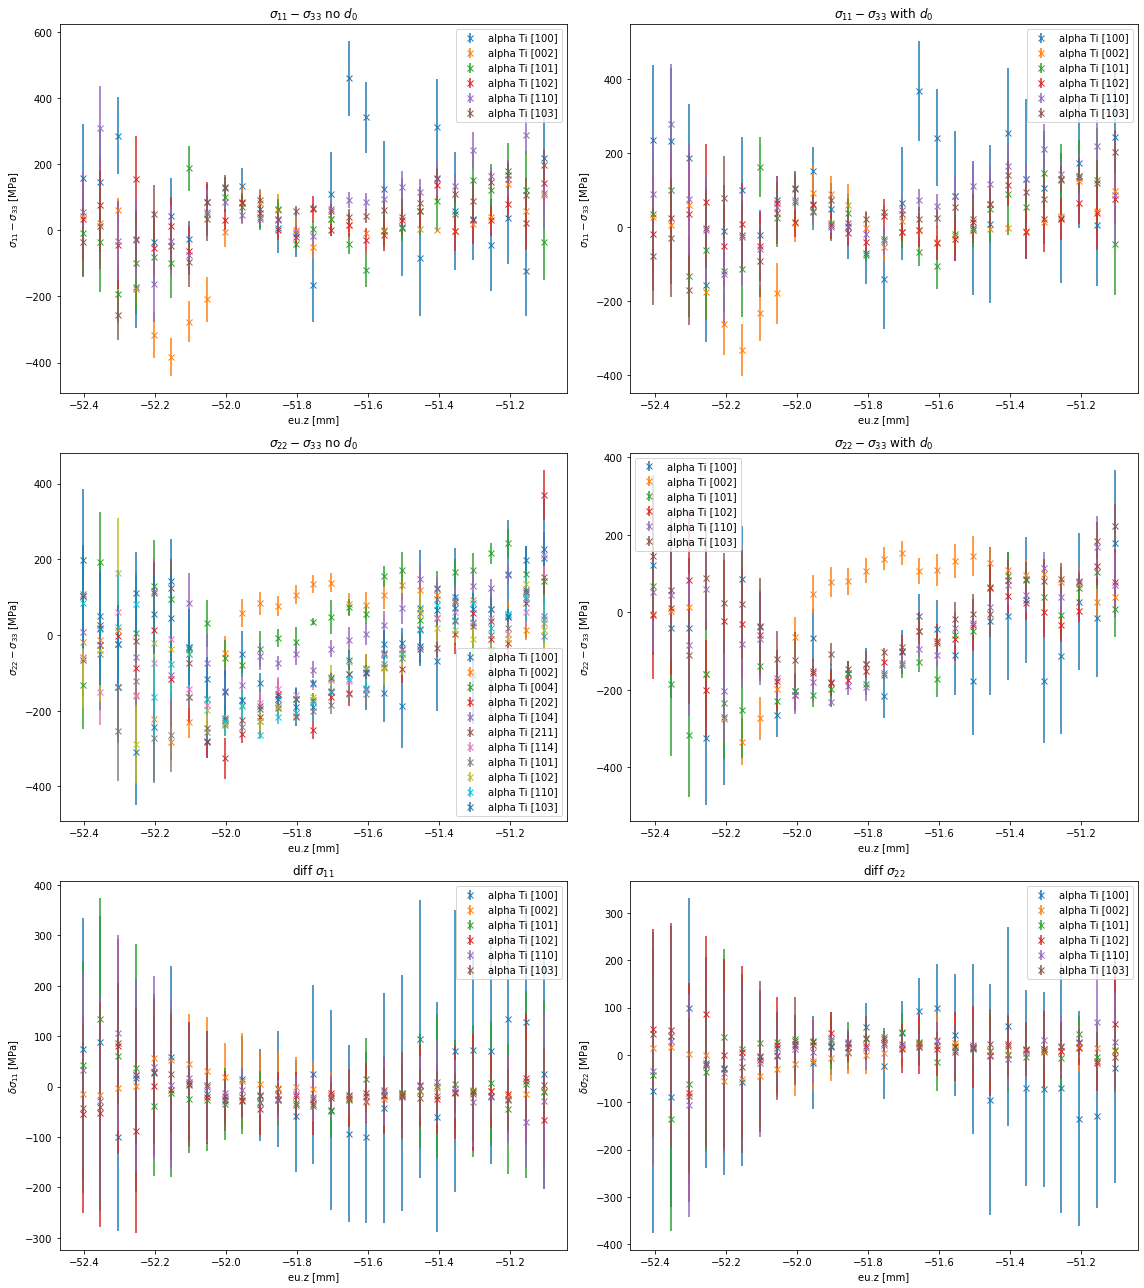

In [6]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

for peak_id in valid_peaks(dd, valid_for='sin2psi'):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 1e-3}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress_dev = deviatoric_stresses(dd, analysis, dec)
stress_dev = stress_dev.reset_index()
stress_dev.set_index('eu.z', inplace=True)

stress = all_stresses(dd, analysis, dec, d0)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)

z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 18))
ax1, ax2 = plt.subplot(321), plt.subplot(322)
ax3, ax4 = plt.subplot(323), plt.subplot(324)
ax5, ax6 = plt.subplot(325), plt.subplot(326)
ax1.set_title(r'$\sigma_{11} - \sigma_{33}$ no $d_0$')
ax2.set_title(r'$\sigma_{11} - \sigma_{33}$ with $d_0$')
ax3.set_title(r'$\sigma_{22} - \sigma_{33}$ no $d_0$')
ax4.set_title(r'$\sigma_{22} - \sigma_{33}$ with $d_0$')
ax5.set_title(r'diff $\sigma_{11}$')
ax6.set_title(r'diff $\sigma_{22}$')
ax1.set_xlabel('eu.z [mm]')
ax2.set_xlabel('eu.z [mm]')
ax3.set_xlabel('eu.z [mm]')
ax4.set_xlabel('eu.z [mm]')
ax5.set_xlabel('eu.z [mm]')
ax6.set_xlabel('eu.z [mm]')
ax1.set_ylabel('$\sigma_{11} - \sigma_{33}$ [MPa]')
ax2.set_ylabel('$\sigma_{11} - \sigma_{33}$ [MPa]')
ax3.set_ylabel('$\sigma_{22} - \sigma_{33}$ [MPa]')
ax4.set_ylabel('$\sigma_{22} - \sigma_{33}$ [MPa]')
ax5.set_ylabel('$\delta \sigma_{11}$ [MPa]')
ax6.set_ylabel('$\delta \sigma_{22}$ [MPa]')

for peak_id in sorted(set(stress_dev.columns.get_level_values(0))):

    if 's11-s33' in stress_dev[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress_dev.index].values.flatten(),
            y=unumpy.nominal_values(stress_dev.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress_dev.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress_dev[peak_id].columns:
        ax3.errorbar(
            x=z_pos.loc[stress_dev.index].values.flatten(),
            y=unumpy.nominal_values(stress_dev.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress_dev.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

for peak_id in sorted(set(stress.columns.get_level_values(0))):

    if ('s11' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's11')] - stress.loc[:, (peak_id, 's33')]
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if ('s22' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's22')] - stress.loc[:, (peak_id, 's33')]
        ax4.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

        
for peak_id in sorted(set(stress.columns.get_level_values(0)) & set(stress_dev.columns.get_level_values(0))):
    
    if ('s11-s33' in stress_dev[peak_id].columns) and ('s11' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's11')] - stress.loc[:, (peak_id, 's33')] - stress_dev.loc[:, (peak_id, 's11-s33')]
        ax5.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
    
    if ('s22-s33' in stress_dev[peak_id].columns) and ('s22' in stress[peak_id].columns) and ('s33' in stress[peak_id].columns):
        yy = stress.loc[:, (peak_id, 's22')] - stress.loc[:, (peak_id, 's33')] - stress_dev.loc[:, (peak_id, 's22-s33')]
        ax6.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(yy),
            yerr=unumpy.std_devs(yy),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()

plt.tight_layout()
plt.show()